In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from typing import Tuple, List, Optional
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

In [131]:
def euclidean_squared(p1: np.ndarray, p2: np.ndarray) -> float:
    return np.sum((p1 - p2) ** 2)

In [5]:
def custom_kmeans(data: np.ndarray, k: int, max_iters: int = 100, tol: float = 1e-4, 
                 random_state: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    # Set random seed
    np.random.seed(random_state)
    
    # Initialize centroids by selecting random data points
    initial_indices = np.random.choice(len(data), k, replace=False)
    centroids = data[initial_indices].copy()
    
    labels = np.zeros(len(data), dtype=int)
    
    for iteration in range(max_iters):
        distances = np.zeros((len(data), k))
        for i in range(k):
            sq_diff = (data - centroids[i]) ** 2
            distances[:, i] = np.sum(sq_diff, axis=1)
        
        # Assign each point to the nearest centroid
        new_labels = np.argmin(distances, axis=1)
        
        # Check if labels changed
        if np.array_equal(labels, new_labels) and iteration > 0:
            print(f"K-means converged after {iteration+1} iterations (no label changes)")
            break
            
        labels = new_labels
        
        # Update centroids based on mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            # If cluster is empty, keep the old centroid
            if np.sum(labels == i) > 0:
                new_centroids[i] = np.mean(data[labels == i], axis=0)
            else:
                new_centroids[i] = centroids[i]
        
        # Check for convergence (using squared Euclidean distance)
        shift = np.sum((centroids - new_centroids) ** 2)
        if shift < tol:
            print(f"K-means converged after {iteration+1} iterations (centroid shift < {tol})")
            break
        
        centroids = new_centroids
    
    if iteration == max_iters - 1:
        print(f"Warning: K-means did not converge after {max_iters} iterations")
    
    return centroids, labels

In [6]:
def calculate_silhouette_score(data: np.ndarray, labels: np.ndarray) -> float:
    # We need at least 2 clusters and each cluster needs at least 2 samples
    # to calculate silhouette score
    n_clusters = len(np.unique(labels))
    if n_clusters <= 1 or n_clusters >= len(data):
        return -1.0
    
    # Check that each cluster has at least 2 samples
    for i in range(n_clusters):
        if np.sum(labels == i) <= 1:
            print(f"Warning: Cluster {i} has only {np.sum(labels == i)} samples, silhouette score may be unreliable")
            return -1.0
    
    try:
        # Calculate silhouette score using sklearn
        # The metric 'euclidean' is used since we're using Euclidean distance in K-means
        return silhouette_score(data, labels, metric='euclidean')
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        return -1.0

In [7]:
def visualize_silhouette(data: np.ndarray, labels: np.ndarray, silhouette_avg: float) -> None:
    n_clusters = len(np.unique(labels))
    
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, labels, metric='euclidean')
    
    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    y_lower = 10
    
    # Plot silhouette scores for each cluster
    for i in range(n_clusters):
        # Get silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i+1}')
        
        # Calculate new y_lower for next plot
        y_lower = y_upper + 10
    
    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
              label=f'Average silhouette score: {silhouette_avg:.3f}')
    
    # Set plot title and labels
    ax.set_title("Silhouette Plot for K-Means Clustering")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")
    
    # Set x axis limits
    ax.set_xlim([-0.1, 1])
    
    # Add a legend
    ax.legend(loc="best")
    
    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_kmeans_clustering(data: np.ndarray, k_values: List[int]) -> Tuple[List[float], List[float]]:
    silhouette_scores = []
    inertia_values = []
    
    print("\nEvaluating different numbers of clusters (k):")
    print("-" * 50)
    
    for k in k_values:
        print(f"\nEvaluating k={k}:")
        
        # Perform K-means clustering
        centroids, labels = custom_kmeans(data, k, random_state=42)
        
        # Calculate silhouette score
        sil_score = calculate_silhouette_score(data, labels)
        silhouette_scores.append(sil_score)
        
        # Calculate inertia (sum of squared distances to nearest centroid)
        inertia = 0
        for i in range(len(data)):
            # Calculate squared distance to assigned centroid
            cluster_idx = labels[i]
            inertia += euclidean_squared(data[i], centroids[cluster_idx])
        inertia_values.append(inertia)
        
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Inertia: {inertia:.2f}")
        
        # Count samples in each cluster
        for i in range(k):
            count = np.sum(labels == i)
            print(f"  Cluster {i+1}: {count} samples ({count/len(data)*100:.1f}%)")
    
    print("\nSummary of clustering evaluation:")
    print("-" * 50)
    print("k\tSilhouette\tInertia")
    for i, k in enumerate(k_values):
        print(f"{k}\t{silhouette_scores[i]:.4f}\t\t{inertia_values[i]:.2f}")
    
    return silhouette_scores, inertia_values

In [139]:
def plot_evaluation_metrics(k_values: List[int], silhouette_scores: List[float], inertia_values: List[float]) -> None:
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot silhouette scores
    #ax1.plot(k_values, silhouette_scores, 'o-', color='blue')
    #ax1.set_xlabel('Number of Clusters (k)')
    #ax1.set_ylabel('Silhouette Score')
    #ax1.set_title('Silhouette Score vs. Number of Clusters')
    #ax1.grid(True, alpha=0.3)
    #ax1.set_xticks(k_values)
    
    # Highlight the best k value based on silhouette score
    best_k_index = np.argmax(silhouette_scores)
    best_k = k_values[best_k_index]
    best_score = silhouette_scores[best_k_index]
    #ax1.scatter([best_k], [best_score], color='red', s=100, zorder=5)
    #ax1.annotate(f'Best k={best_k}\nScore={best_score:.4f}', 
                #xy=(best_k, best_score), xytext=(best_k + 0.5, best_score - 0.03),
                #arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Plot inertia values (elbow method)
    plt.plot(k_values, inertia_values, 'o-', color='green')
    plt.set_xlabel('Number of Clusters (k)')
    plt.set_ylabel('Inertia (Sum of Squared Distances)')
    plt.set_title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.set_xticks(k_values)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBased on silhouette score, the optimal number of clusters is k={best_k} with score {best_score:.4f}")
    
    # Find the elbow point (where the rate of decrease slows down significantly)
    # Simple heuristic: point with maximum second derivative
    if len(k_values) >= 3:
        diffs = np.diff(inertia_values)
        second_diffs = np.diff(diffs)
        elbow_idx = np.argmax(second_diffs) + 1  # +1 because of diff
        elbow_k = k_values[elbow_idx]
        print(f"Based on the elbow method, a good number of clusters is around k={elbow_k}")
    
    return best_k

In [10]:
def assign_centroid_genres(data: np.ndarray, 
                          centroids: np.ndarray, 
                          song_df: pd.DataFrame, 
                          labels: np.ndarray,
                          num_closest: int = 20) -> List[str]:
    centroid_genre_labels = []
    
    for i in range(len(centroids)):
        # Find songs assigned to this cluster
        cluster_songs = data[labels == i]
        cluster_indices = np.where(labels == i)[0]
        
        # If we have fewer than num_closest songs in the cluster, use all of them
        # Otherwise, find the num_closest songs closest to the centroid
        if len(cluster_songs) <= num_closest:
            closest_indices = cluster_indices
        else:
            # Calculate distances within the cluster
            distances = np.zeros(len(cluster_songs))
            for j in range(len(cluster_songs)):
                sq_diff = (cluster_songs[j] - centroids[i]) ** 2
                distances[j] = np.sum(sq_diff)
                
            # Get indices of closest songs within this cluster
            closest_in_cluster = np.argsort(distances)[:num_closest]
            closest_indices = cluster_indices[closest_in_cluster]
        
        # Get genres of the closest songs
        closest_genres = song_df['Genres'].iloc[closest_indices].tolist()
        
        # Count genre occurrences (normalized)
        genre_counts = pd.Series(closest_genres).value_counts(normalize=True)
        
        # Determine dominant genre
        if not genre_counts.empty:
            dominant_genre = genre_counts.idxmax()
            dominant_percentage = genre_counts.max()
            
            # If one genre is clearly dominant (>= 60%), use it
            # Otherwise, create a fusion or mixed label
            if dominant_percentage >= 0.6:
                centroid_genre_labels.append(dominant_genre)
            else:
                # Get top 2 genres
                top_genres = genre_counts.head(2).index.tolist()
                if len(top_genres) == 2:
                    centroid_genre_labels.append(f"{top_genres[0]}-{top_genres[1]}")
                else:
                    centroid_genre_labels.append("Mixed")
        else:
            centroid_genre_labels.append("Unknown")
    
    return centroid_genre_labels

In [11]:
def get_recommendations(selected_song_coordinates: np.ndarray, 
                       data: np.ndarray, 
                       song_df: pd.DataFrame, 
                       num_closest: int = 10) -> Tuple[str, List[str], np.ndarray]:

    selected_song_coordinates = np.asarray(selected_song_coordinates).reshape(1, -1)
    
    # Calculate manually squared Euclidean distances to each point in the dataset
    distances = np.sum((data - selected_song_coordinates) ** 2, axis=1)
    
    # Sort the distances and get the indices of the closest songs
    closest_indices = np.argsort(distances)[:num_closest]
    
    # Get the recommended songs
    recommended_songs = song_df.iloc[closest_indices]
    
    # Select the closest song
    closest_song = recommended_songs.iloc[0]
    
    # Print the selected song and recommendations
    print(f"\n🎵 RECOMMENDATION RESULTS:")
    print(f"Top Match: {closest_song['Track Name']} (Genre: {closest_song['Genres']})")
    print("\n🎧 Full Recommendation Playlist:")
    for i, song in enumerate(recommended_songs['Track Name'], 1):
        genre = recommended_songs.iloc[i-1]['Genres']
        print(f"{i}. {song} (Genre: {genre})")
    
    return closest_song['Track Name'], recommended_songs['Track Name'].tolist(), closest_indices

In [12]:
def plot_clusters_3d_interactive(data: np.ndarray, 
                                centroids: np.ndarray, 
                                labels: np.ndarray, 
                                song_names: List[str], 
                                centroid_labels: Optional[List[str]] = None,
                                selected_song_coordinates: Optional[np.ndarray] = None, 
                                closest_indices: Optional[np.ndarray] = None) -> None:
    fig = go.Figure()
    
    # Create a color map based on cluster labels for better distinction
    cluster_colors = labels
    
    # Plot all songs
    fig.add_trace(go.Scatter3d(
        x=data[:, 0],
        y=data[:, 1],
        z=data[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=cluster_colors,
            colorscale='Viridis',
            opacity=0.7
        ),
        text=[f"Song: {name}" for name in song_names],
        hoverinfo='text',
        name='Songs'
    ))

    # Add cluster centroids with genre labels if available
    if centroid_labels:
        centroid_texts = [f"Cluster {i+1}: {label}" for i, label in enumerate(centroid_labels)]
    else:
        centroid_texts = [f"Cluster {i+1}" for i in range(len(centroids))]
    
    fig.add_trace(go.Scatter3d(
        x=centroids[:, 0],
        y=centroids[:, 1],
        z=centroids[:, 2],
        mode='markers+text',
        marker=dict(
            size=12,
            color='black',
            symbol='diamond',
            line=dict(color='white', width=1)
        ),
        text=centroid_texts,
        textposition="top center",
        hoverinfo='text',
        name='Centroids'
    ))

    # Add selected song if provided
    if selected_song_coordinates is not None:
        fig.add_trace(go.Scatter3d(
            x=[selected_song_coordinates[0]],
            y=[selected_song_coordinates[1]],
            z=[selected_song_coordinates[2]],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='cross',
                line=dict(color='white', width=1)
            ),
            text=["Selected Song"],
            hoverinfo='text',
            name='Selected Song'
        ))

    # Add recommended songs if provided
    if closest_indices is not None:
        recommended_points = data[closest_indices]
        recommended_titles = [song_names[i] for i in closest_indices]
        
        fig.add_trace(go.Scatter3d(
            x=recommended_points[:, 0],
            y=recommended_points[:, 1],
            z=recommended_points[:, 2],
            mode='markers',
            marker=dict(
                size=8,
                color='magenta',
                symbol='circle',
                line=dict(color='white', width=1)
            ),
            text=[f"Recommendation: {title}" for title in recommended_titles],
            hoverinfo='text',
            name='Recommendations'
        ))

    fig.update_layout(
        title="3D Music Recommendation Visualization",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
            xaxis=dict(backgroundcolor="rgb(230, 230, 230)"),
            yaxis=dict(backgroundcolor="rgb(230, 230, 230)"),
            zaxis=dict(backgroundcolor="rgb(230, 230, 230)")
        ),
        margin=dict(l=0, r=0, b=0, t=30),
        legend=dict(
            x=0,
            y=1,
            bgcolor="rgba(255, 255, 255, 0.5)"
        )
    )
    
    fig.show()

In [13]:
def select_random_song(df: pd.DataFrame) -> Tuple[np.ndarray, pd.Series]:
    current_seed = int(time.time()) #random seed
    random.seed(current_seed)
    
    # Select a random song
    random_idx = random.randint(0, len(df) - 1)
    selected_song = df.iloc[random_idx]
    
    # Extract coordinates
    coordinates = selected_song[['PC1', 'PC2', 'PC3']].values
    
    print(f"\n🎵 SELECTED INPUT SONG:")
    print(f"Song: {selected_song['Track Name']}")
    print(f"Genre: {selected_song['Genres']}")
    print(f"Random selection index: {random_idx} (using time-based seed: {current_seed})")
    
    return coordinates, selected_song

In [14]:
def select_song_by_name(df: pd.DataFrame, song_name: str) -> Tuple[Optional[np.ndarray], Optional[pd.Series]]:
    matches = df[df['Track Name'].str.lower().str.contains(song_name.lower())] #case insensitive
    
    if len(matches) == 0:
        print(f"No songs found matching '{song_name}'")
        return None, None
    
    if len(matches) > 1:
        print(f"Found {len(matches)} songs matching '{song_name}'. Using the first match:")
        print(matches['Track Name'].tolist())
    
    # Use the first match
    selected_song = matches.iloc[0]
    
    # Extract coordinates
    coordinates = selected_song[['PC1', 'PC2', 'PC3']].values
    
    print(f"\n🎵 SELECTED INPUT SONG:")
    print(f"Song: {selected_song['Track Name']}")
    print(f"Genre: {selected_song['Genres']}")
    
    return coordinates, selected_song

In [108]:
print("Loading datasets...")
dataset1_file_path = "genre_cleaned.csv"  #user dataset
dataset2_file_path = "cleaned_mega.csv"  # reference dataset for recommendations

dataset1_df = pd.read_csv(dataset1_file_path)
dataset2_df = pd.read_csv(dataset2_file_path)

print(f"Loaded {len(dataset1_df)} songs in user's dataset")
print(f"Loaded {len(dataset2_df)} songs in recommendation dataset")

Loading datasets...
Loaded 1203 songs in user's dataset
Loaded 13316 songs in recommendation dataset


In [110]:
combined_data = dataset2_df[['PC1', 'PC2', 'PC3']].values
combined_song_names = dataset2_df['Track Name'].tolist()

In [147]:
run_validation = input("\nDo you want to perform model validation? (y/n): ").strip().lower()

k = 6  # Default number of clusters

if run_validation == 'y':
    # Run silhouette score evaluation for different k values
    k_values = list(range(1, 51))
    silhouette_scores, inertia_values = evaluate_kmeans_clustering(combined_data, k_values)
    
    # Plot evaluation metrics
    best_k = plot_evaluation_metrics(k_values, silhouette_scores, inertia_values)
    
    use_best_k = input(f"\nUse recommended k={best_k}? (y/n): ").strip().lower()
    if use_best_k == 'y':
        k = best_k
    else:
        k = int(input("Enter your preferred k value: "))
        
    # For the selected k, visualize the silhouette plot
    print(f"\nCreating silhouette plot for k={k}...")
    centroids, labels = custom_kmeans(combined_data, k, random_state=42)
    silhouette_avg = calculate_silhouette_score(combined_data, labels)
    visualize_silhouette(combined_data, labels, silhouette_avg)


Do you want to perform model validation? (y/n):  n


In [114]:
# Ask user if they want to search for a specific song or use a random one
selection_mode = input("\nDo you want to search for a specific song? (y/n): ").strip().lower()

if selection_mode == 'y':
    song_name = input("Enter song name to search: ")
    selected_song_coordinates, selected_song_info = select_song_by_name(dataset1_df, song_name)
    
    # If no song found, fall back to random selection
    if selected_song_coordinates is None:
        print("Falling back to random song selection...")
        selected_song_coordinates, selected_song_info = select_random_song(dataset1_df)
else:
    # Select a random song from the new dataset
    selected_song_coordinates, selected_song_info = select_random_song(dataset1_df)


Do you want to search for a specific song? (y/n):  n



🎵 SELECTED INPUT SONG:
Song: The Place Where I Belong
Genre: lofi
Random selection index: 177 (using time-based seed: 1744489752)


In [116]:
# Perform clustering on the reference dataset
print(f"\nPerforming custom K-means clustering with k={k}...")
centroids, labels = custom_kmeans(combined_data, k, random_state=42)
print(f"Created {k} clusters from the reference dataset")

# Calculate silhouette score for the final clustering
sil_score = calculate_silhouette_score(combined_data, labels)
print(f"Silhouette score for the final clustering: {sil_score:.4f}")

# Cluster size analysis
print("\nCluster size analysis:")
for i in range(k):
    count = np.sum(labels == i)
    print(f"Cluster {i+1}: {count} songs ({count/len(combined_data)*100:.1f}%)")

# Assign genre labels to centroids
print("\nAssigning genre labels to centroids...")
centroid_genre_labels = assign_centroid_genres(combined_data, centroids, dataset2_df, labels)
print("Centroid genre labels:")
for i, label in enumerate(centroid_genre_labels):
    print(f"Cluster {i+1}: {label}")

# Get recommendations
print("\nFinding song recommendations...")
_, recommendations, closest_indices = get_recommendations(
    selected_song_coordinates, 
    combined_data, 
    dataset2_df, 
    num_closest=10
)


Performing custom K-means clustering with k=6...
K-means converged after 50 iterations (centroid shift < 0.0001)
Created 6 clusters from the reference dataset
Silhouette score for the final clustering: 0.2472

Cluster size analysis:
Cluster 1: 2473 songs (18.6%)
Cluster 2: 736 songs (5.5%)
Cluster 3: 1620 songs (12.2%)
Cluster 4: 3862 songs (29.0%)
Cluster 5: 1859 songs (14.0%)
Cluster 6: 2766 songs (20.8%)

Assigning genre labels to centroids...
Centroid genre labels:
Cluster 1: edm-metal
Cluster 2: pop-country
Cluster 3: metal
Cluster 4: edm-metal
Cluster 5: country-edm
Cluster 6: edm-metal

Finding song recommendations...

🎵 RECOMMENDATION RESULTS:
Top Match: Islands In The Stream (Genre: country)

🎧 Full Recommendation Playlist:
1. Islands In The Stream (Genre: country)
2. Islands In The Stream (Genre: country)
3. Are You Lost in the World Like Me? (Genre: lofi)
4. Anti-Pioneer (Genre: pop)
5. Double Dolphins On the Nickel (Genre: metal)
6. Tangled up in Blue (Genre: country)
7. T

In [117]:
rename_map = {
    'dance': 'Danceability', #
    'energy': 'Energy', #
    'loud': 'Loudness', 
    'speech': 'Speechiness',
    'acoustic': 'Acousticness',
    'instrumental': 'Instrumentalness',
    'valence': 'Valence',
    'tempo': 'Tempo', #
}

dataset2_df.rename(columns=rename_map, inplace=True)
selected_song_info.rename(index=rename_map, inplace=True)

features_to_compare = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness',
    'Acousticness', 'Instrumentalness',
    'Valence', 'Tempo'
]

target_features = selected_song_info[features_to_compare].astype(float).values
rae = []
features = []

for i in range(len(recommendations)):
    song_rae = []
    selected_song_coordinates1, selected_song_info1 = select_song_by_name(dataset2_df, recommendations[i])

    try:
        compared_features = selected_song_info1[features_to_compare].astype(float).values
    except Exception:
        rae.append([-123]) #song not found
        features.append([-123])
        continue

    features.append(compared_features)
    for j in range(len(compared_features)):
        if ((abs(compared_features[j]) < 0.0001) or (abs(target_features[j]) < 0.0001)):
            song_rae.append(0)
        else:
            song_rae.append(abs(target_features[j] - compared_features[j])/abs(target_features[j]))
            
    normalized_rae = np.mean(song_rae)
    rae.append(normalized_rae)

rae

Found 2 songs matching 'Islands In The Stream'. Using the first match:
['Islands In The Stream', 'Islands In The Stream']

🎵 SELECTED INPUT SONG:
Song: Islands In The Stream
Genre: country
Found 2 songs matching 'Islands In The Stream'. Using the first match:
['Islands In The Stream', 'Islands In The Stream']

🎵 SELECTED INPUT SONG:
Song: Islands In The Stream
Genre: country

🎵 SELECTED INPUT SONG:
Song: Are You Lost in the World Like Me?
Genre: lofi

🎵 SELECTED INPUT SONG:
Song: Anti-Pioneer
Genre: pop

🎵 SELECTED INPUT SONG:
Song: Double Dolphins On the Nickel
Genre: metal

🎵 SELECTED INPUT SONG:
Song: Tangled up in Blue
Genre: country

🎵 SELECTED INPUT SONG:
Song: This Girl's In Love With You
Genre: pop

🎵 SELECTED INPUT SONG:
Song: Minnesang
Genre: pop
Found 3 songs matching 'This Land'. Using the first match:
['Follow This Land', 'This Land', 'This Land is Your Land']

🎵 SELECTED INPUT SONG:
Song: Follow This Land
Genre: metal

🎵 SELECTED INPUT SONG:
Song: California Kids
Genre: m

C:\Users\omp12\AppData\Local\Temp\ipykernel_19064\2566570974.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[0.9390580914462499,
 0.9390580914462499,
 1.1245192959563197,
 0.48888678530328045,
 0.4789258328921994,
 0.6314630229643797,
 0.40381904621497955,
 0.2652202384188873,
 0.9781871023542221,
 1.298508053757018]

In [120]:
for j in range(len(features_to_compare)):
    print(f"{selected_song_info['Track Name']}, {features_to_compare[j]}: {target_features[j]}")

The Place Where I Belong, Danceability: 0.558
The Place Where I Belong, Energy: 0.155
The Place Where I Belong, Loudness: -16.207
The Place Where I Belong, Speechiness: 0.0427
The Place Where I Belong, Acousticness: 0.689
The Place Where I Belong, Instrumentalness: 0.857
The Place Where I Belong, Valence: 0.352
The Place Where I Belong, Tempo: 73.993


In [122]:
i = 0
for song in recommendations:
    for j in range(len(features_to_compare)):
        print(f"{song}, {features_to_compare[j]}: {features[i][j]}")
    i += 1

Islands In The Stream, Danceability: 0.589
Islands In The Stream, Energy: 0.641
Islands In The Stream, Loudness: -5.533
Islands In The Stream, Speechiness: 0.0313
Islands In The Stream, Acousticness: 0.427
Islands In The Stream, Instrumentalness: 0.0
Islands In The Stream, Valence: 0.795
Islands In The Stream, Tempo: 204.003
Islands In The Stream, Danceability: 0.589
Islands In The Stream, Energy: 0.641
Islands In The Stream, Loudness: -5.533
Islands In The Stream, Speechiness: 0.0313
Islands In The Stream, Acousticness: 0.427
Islands In The Stream, Instrumentalness: 0.0
Islands In The Stream, Valence: 0.795
Islands In The Stream, Tempo: 204.003
Are You Lost in the World Like Me?, Danceability: 0.369
Are You Lost in the World Like Me?, Energy: 0.922
Are You Lost in the World Like Me?, Loudness: -3.714
Are You Lost in the World Like Me?, Speechiness: 0.0347
Are You Lost in the World Like Me?, Acousticness: 2.64e-05
Are You Lost in the World Like Me?, Instrumentalness: 0.0114
Are You Los


Generating 3D visualization...


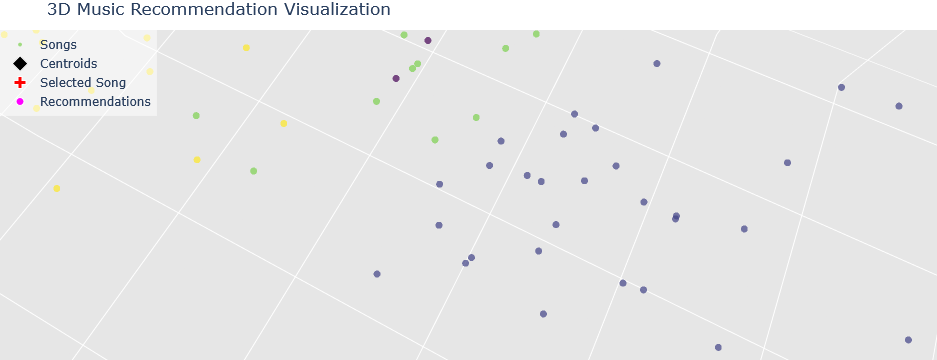

In [124]:
print("\nGenerating 3D visualization...")
fig = go.Figure()
plot_clusters_3d_interactive(
    combined_data,
    centroids,
    labels,
    combined_song_names,
    centroid_labels=centroid_genre_labels,
    selected_song_coordinates=selected_song_coordinates,
    closest_indices=closest_indices
)